In [180]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ppscore as pps
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor as GBR
## for explainer
from lime import lime_tabular

In [650]:
df = pd.read_excel("../State Population Data.xlsx", sheet_name='Final Sheet2')
df = df.drop(labels=['index_sa'], axis=1)
# df = df.rename(columns={"index_nsa":"Y"})
df

,State,Year,Longitude,Latitude,Under 10 years,10 to 19 years,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years and over,Total Population,Average Age,index_nsa
0,Alabama,2010,32.806671,-86.79113,611499,660945,648862,606011,657024,661952,489007,284692,165445,4785437,37.878929,181.0125
1,Alabama,2011,32.806671,-86.79113,607478,651398,656655,600662,651601,669537,504464,289390,167884,4799069,38.099774,172.0450
2,Alabama,2012,32.806671,-86.79113,604911,643571,663390,599214,644040,674847,519018,296252,170345,4815588,38.301765,175.7075
3,Alabama,2013,32.806671,-86.79113,601612,637888,668736,599563,634782,678534,529342,307773,171851,4830081,38.494690,180.6275
4,Alabama,2014,32.806671,-86.79113,599751,632148,671034,600425,623280,679491,543971,317152,174547,4841799,38.691959,184.7300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,Wyoming,2015,42.755966,-107.30249,79546,74569,82451,78615,66095,80570,69132,34738,19897,585613,37.980726,319.2800
506,Wyoming,2016,42.755966,-107.30249,78247,74883,80572,79284,65877,77572,71731,35801,20248,584215,38.207392,322.2875
507,Wyoming,2017,42.755966,-107.30249,75588,75052,78067,78375,65693,74163,72735,38482,20776,578931,38.578825,327.6575
508,Wyoming,2018,42.755966,-107.30249,73634,75354,77018,78050,66040,71655,73912,40748,21190,577601,38.870829,339.6875


## 1 - Data Analysis

c:\Users\jerem\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


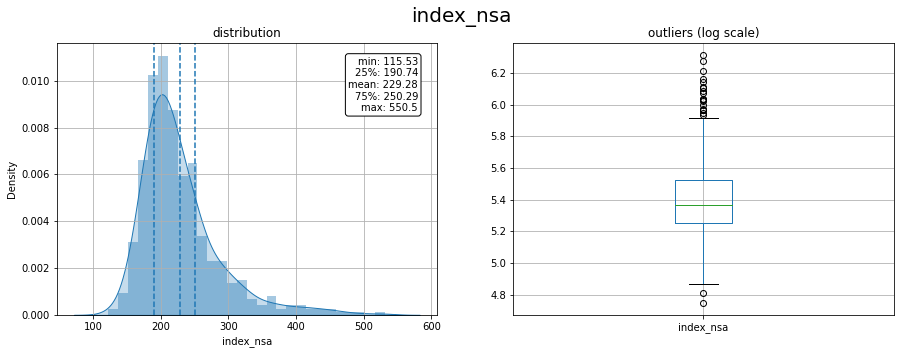

In [633]:
x = "index_nsa"

fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15,5))
fig.suptitle(x, fontsize=20, color="black")

ax[0].title.set_text('distribution')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(df[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

## Used for Testing Indiviual Columns against the Target Variable

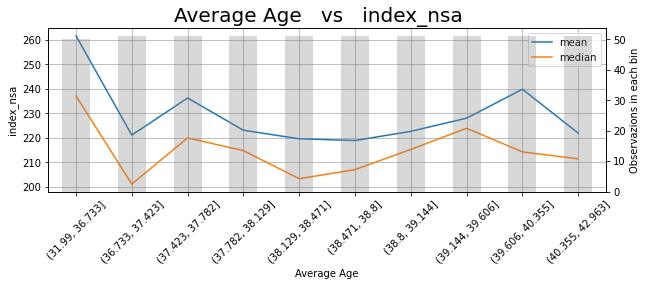

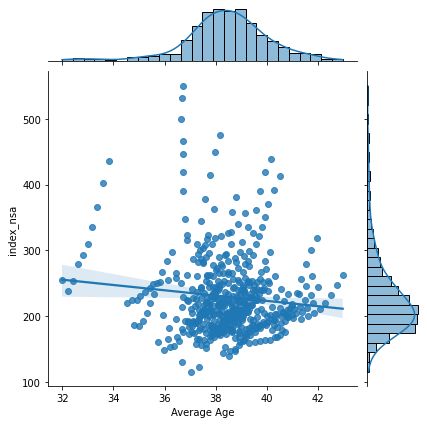

In [638]:
x_value = "Average Age"
y_value = "index_nsa"
x, y = x_value, y_value
### bin plot
dtf_noNan = df[df[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg', 
              height=int((10+3)/2) )
plt.show()

In [639]:
x, y = x_value, y_value
dtf_noNan = df[df[x].notnull()]
coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)

#assuming that two variables are independent (null hypothesis)
#it tests whether two samples have a linear relationship. 
# If the p-value is small enough (<0.05), the null hypothesis can be rejected 
# and we can say that the two variables are probably dependent.

conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: -0.106 Significant (p-value: 0.017)


End of individual column testing ---------------------------

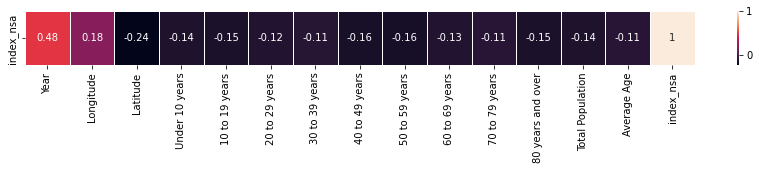

In [640]:
fig, ax = plt.subplots(figsize=(15,1))       
corrMatrix = df.corr(method="pearson")
sns.heatmap(corrMatrix.iloc[14:15,0:15], annot=True, linewidths=.5, ax=ax)
plt.show()

In [641]:
X_train = pd.read_csv("X_train.csv")
X_train = X_train.rename(columns={"Unnamed: 0":"Index"})
X_train = X_train.set_index("Index")

y_train = pd.read_csv("y_train.csv")
y_train = y_train.rename(columns={"Unnamed: 0":"Index"})
y_train = y_train.set_index("Index")

X_test = pd.read_csv("X_test.csv")
X_test = X_test.rename(columns={"Unnamed: 0":"Index"})
X_test = X_test.set_index("Index")

y_test = pd.read_csv("y_test.csv")
y_test = y_test.rename(columns={"Unnamed: 0":"Index"})
y_test = y_test.set_index("Index")

X_train = X_train.drop(labels=['State', 'Year'], axis=1)
X_test = X_test.drop(labels=['State', 'Year'], axis=1)

print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train['index_nsa']),2), "| y_test mean:", round(np.mean(y_test['index_nsa']),2))
print(df.shape[1], "features:", df.drop("index_nsa",axis=1).columns.to_list())

X_train shape: (357, 13) | X_test shape: (153, 13)
y_train mean: 230.65 | y_test mean: 226.08
16 features: ['State', 'Year', 'Longitude', 'Latitude', 'Under 10 years', '10 to 19 years', '20 to 29 years', '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years', '70 to 79 years', '80 years and over', 'Total Population', 'Average Age']


In [567]:
X_train['Average 15-Year Mortgage Interest Rates'] = X_train['Average 15-Year Mortgage Interest Rates'].fillna(X_train['Average 15-Year Mortgage Interest Rates'].mean())
X_train['Average 30-Year Mortgage Interest Rates'] = X_train['Average 30-Year Mortgage Interest Rates'].fillna(X_train['Average 30-Year Mortgage Interest Rates'].mean())

X_test['Average 15-Year Mortgage Interest Rates'] = X_test['Average 15-Year Mortgage Interest Rates'].fillna(X_test['Average 15-Year Mortgage Interest Rates'].mean())
X_test['Average 30-Year Mortgage Interest Rates'] = X_test['Average 30-Year Mortgage Interest Rates'].fillna(X_test['Average 30-Year Mortgage Interest Rates'].mean())

In [642]:
df_train = X_train
df_train[y] = y_train
df_train

,Longitude,Latitude,Under 10 years,10 to 19 years,20 to 29 years,30 to 39 years,40 to 49 years,50 to 59 years,60 to 69 years,70 to 79 years,80 years and over,Total Population,Average Age,index_nsa
Index,,,,,,,,,,,,,,
284,38.313515,-117.055374,366340,358499,388551,387739,381509,372480,307486,174608,80416,2817628,37.867694,171.1175
266,46.921925,-110.454353,126707,126871,141026,129744,114658,143476,140712,74674,42991,1040859,39.924919,351.0425
485,38.491226,-80.954453,206175,216389,232719,219082,233488,265721,247511,140379,80586,1842050,40.970597,201.9475
97,27.766279,-81.686783,2290626,2385429,2696112,2602905,2580576,2859677,2590378,1860948,1096962,20963613,41.519623,278.8525
51,39.059811,-105.311104,693619,679917,736539,714860,716143,714426,484191,233388,148025,5121108,36.650738,249.5450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,31.054487,-97.563461,4052430,4121278,4145534,4098196,3689306,3411778,2740689,1561922,807533,28628666,36.077188,283.3250
457,44.045876,-72.710686,61540,76129,83482,72174,73363,93549,87939,49181,26987,624344,41.498167,224.5550
40,36.116203,-119.681564,5034897,5392225,5533503,5147727,5294932,4791408,3167536,1745619,1211655,37319502,36.123560,164.8500


Feature Selection

Text(0.5, 1.0, 'pearson correlation')

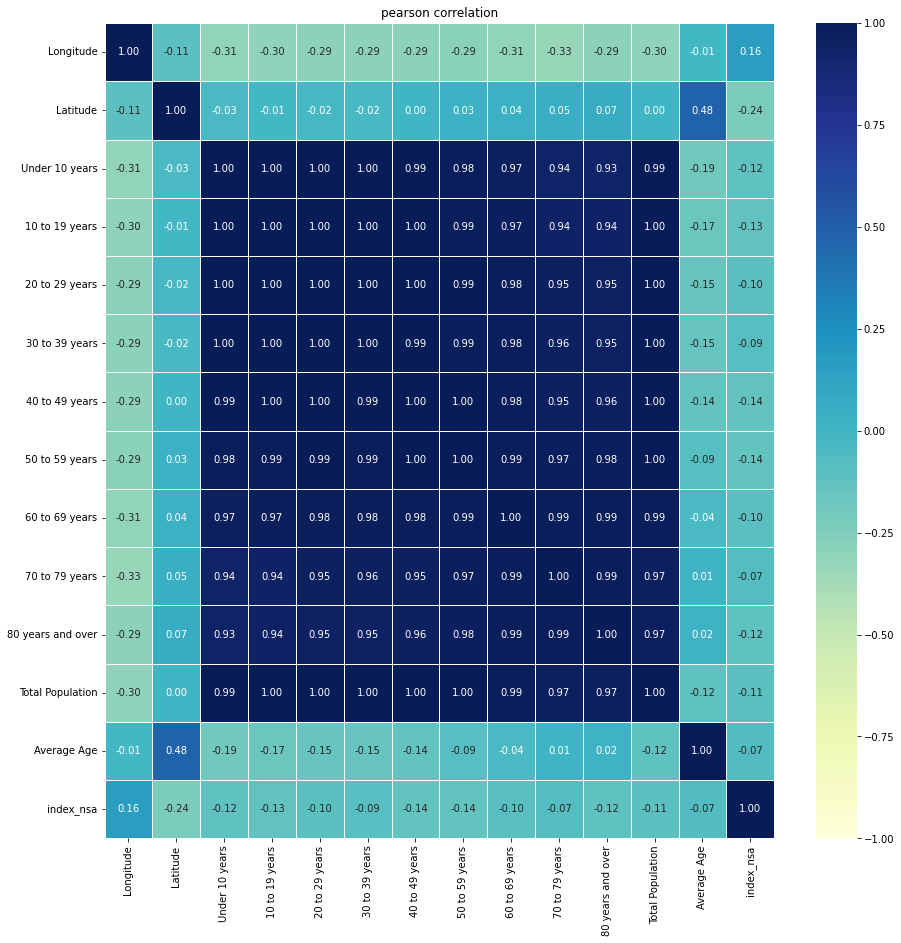

In [643]:
fig, ax = plt.subplots(figsize=(15,15)) 
corr_matrix = df_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
plt.title("pearson correlation")

c:\Users\jerem\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.03621e-17): result may not be accurate.
  overwrite_a=True).T


<AxesSubplot:xlabel='selection', ylabel='features'>

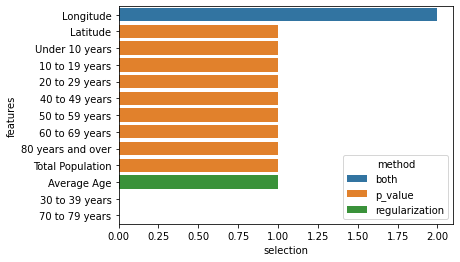

In [644]:
#RIDGE regularization
X = df_train.drop(y, axis=1).values
Y = df_train[y].values
feature_names = df_train.drop(y, axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,Y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,Y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

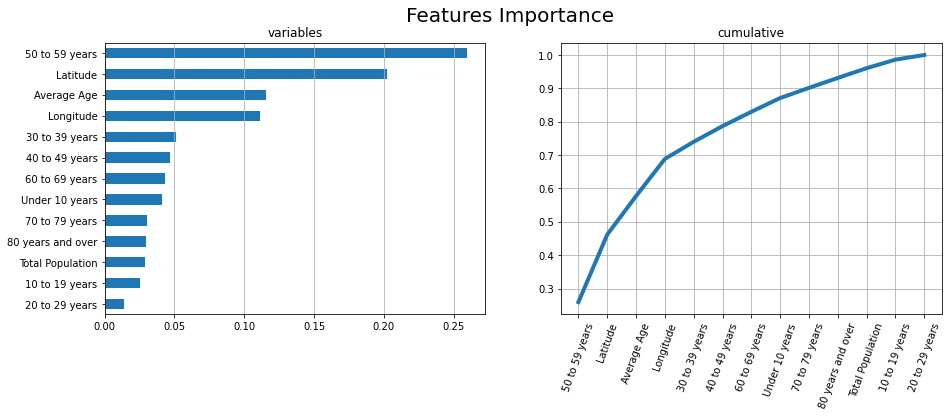

In [645]:
#Ensemble Methods
X = df_train.drop(y, axis=1).values
Y = df_train[y].values
feature_names = df_train.drop(y, axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,Y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,5))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables') 
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [646]:
#Sheet1
# X_names = ['50 to 54 years',
#             '45 to 49 years',
#             '20 to 24 years',
#             'Total Population']

#Sheet2
X_names = ['Longitude',
            'Latitude',
            '40 to 49 years',
            '50 to 59 years',
            'Average Age',
            'Total Population']

# Sheet3
# X_names = ['40 to 59 years',
#             '20 to 39 years',
#             '80 years and over',
#             'Latitude', 
#             'Longitude',
#             'Average Unemployment Rate',
#             'Average Age',
#             'Total Population']

X_train = X_train[X_names].values
y_train = y_train[y].values

X_test = X_test[X_names].values
y_test = y_test[y].values

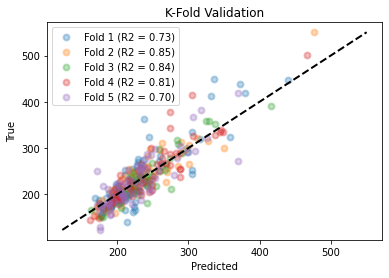

In [647]:
## call model
# model = linear_model.LinearRegression()
model = GBR()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [648]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

Evaluation

In [649]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.10f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.10f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.10f}".format(max_error))

R2 (explained variance): 0.87
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.07
Mean Absolute Error (Σ|y-pred|/n): 15.5014353326
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 22.7739010062
Max Error: 128.8381293725


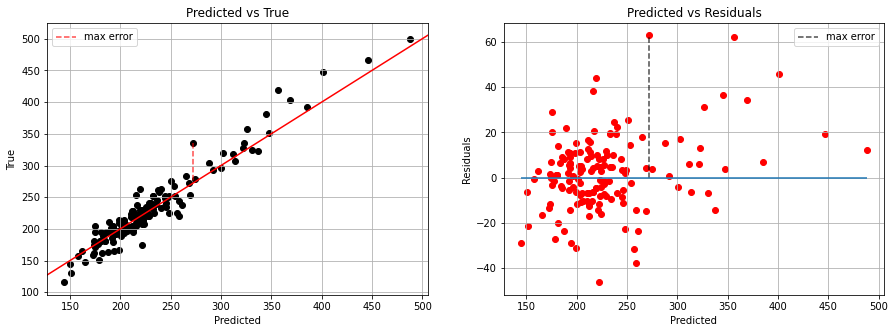

In [560]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

c:\Users\jerem\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


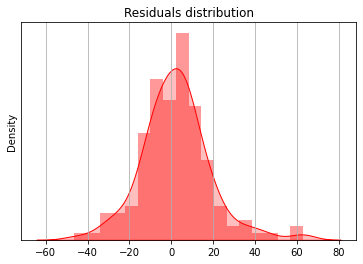

In [561]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

Explainability

In [564]:
print("True:", "{:,.10f}".format(y_test[12]), "--> Pred:", "{:,.10f}".format(predicted[12]))

True: 235.8250000000 --> Pred: 244.6244777378


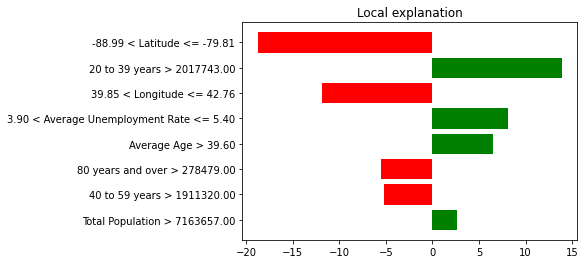

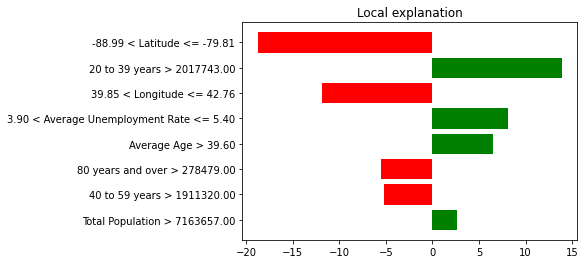

In [565]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()